In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns",500)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def import_data():
  df_flights=pd.read_csv("/content/drive/My Drive/ML/Datasets/Nyc_Airline/nyc_flights.csv")
  df_weather=pd.read_csv("/content/drive/My Drive/ML/Datasets/Nyc_Airline/nyc_weather.csv")
  df_planes=pd.read_csv("/content/drive/My Drive/ML/Datasets/Nyc_Airline/nyc_planes.csv")
  df_airport=pd.read_csv("/content/drive/My Drive/ML/Datasets/Nyc_Airline/nyc_airports.csv")
  # We are merging Lat,log, alt based on origin from df_airport
  df_merge0=pd.merge(df_flights,df_airport[["faa","lat","lon","alt"]],left_on="origin",right_on="faa",how="left")
  df_merge0.drop(["faa"],inplace=True,axis=1)
  # we are merging df_planes with all data
  df_merge1=pd.merge(df_merge0,df_planes,on="tailnum",how="left")
  # Removing some unwanted columns
  df_merge1.drop(["speed","arr_time","dep_time","time_hour"],inplace=True,axis=1)
  # Weather data is hour base so we convert that data into daily basis and then merge with all data
  df_weather_updated=df_weather.groupby(by=['origin','year', 'month', 'day'])[['temp', 'dewp', 'humid',
       'wind_dir', 'wind_speed',  'precip', 'pressure', 'visib']].mean()
  df_merge_done=pd.merge(df_merge1,df_weather_updated,left_on=['origin','year_x','month','day'],right_index=True,how="left")
  return df_merge_done
df=import_data()
df.head()

,year_x,month,day,sched_dep_time,dep_delay,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,lat,lon,alt,year_y,type,manufacturer,model,engines,seats,engine,temp,dewp,humid,wind_dir,wind_speed,precip,pressure,visib
0,2013,1,1,515,2.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,40.692500,-74.168667,18,1999.0,Fixed wing multi engine,BOEING,737-824,2.0,149.0,Turbo-fan,36.819091,22.672727,56.748182,281.818182,13.233970,0.0,1013.085714,10.000000
1,2013,1,1,529,4.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,40.777245,-73.872608,22,1998.0,Fixed wing multi engine,BOEING,737-824,2.0,149.0,Turbo-fan,37.227826,21.959130,53.883478,290.000000,15.410445,0.0,1012.622727,9.956522
2,2013,1,1,540,2.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,40.639751,-73.778925,13,1990.0,Fixed wing multi engine,BOEING,757-223,2.0,178.0,Turbo-fan,36.941818,21.756364,54.291818,291.818182,15.430914,0.0,1013.219048,10.000000
3,2013,1,1,545,-1.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,40.639751,-73.778925,13,2012.0,Fixed wing multi engine,AIRBUS,A320-232,2.0,200.0,Turbo-fan,36.941818,21.756364,54.291818,291.818182,15.430914,0.0,1013.219048,10.000000
4,2013,1,1,600,-6.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,40.777245,-73.872608,22,1991.0,Fixed wing multi engine,BOEING,757-232,2.0,178.0,Turbo-fan,37.227826,21.959130,53.883478,290.000000,15.410445,0.0,1012.622727,9.956522


# Approch 1
## Drop Nan

In [ ]:
#In this approch we drop the rows which contains nan values.
def Approch1():
  df1=df.copy()
  df1.dropna(inplace=True)
  # print(df1.shape)
  return df1
df1=Approch1()

# Preprocessing

In [ ]:
def _preprocessing(data):

  # carrier(Nominal data) contains limited cat values so we should use one hot encoding
  carrier=pd.get_dummies(data["carrier"],drop_first=True)
  data=pd.concat([data,carrier],axis=1)
  data.drop("carrier",axis=1,inplace=True)
  
  #origin(Nominal data) contains 3 categorical values so we should go with one hot encoading
  origin=pd.get_dummies(data["origin"],drop_first=True)
  data=pd.concat([data,origin],axis=1)
  data.drop("origin",axis=1,inplace=True)

  #type(Nominal data) contains limited categorical values so we should go with one hot encoading
  type=pd.get_dummies(data["type"],drop_first=True)
  data=pd.concat([data,type],axis=1)
  data.drop("type",axis=1,inplace=True)

  #engine(Nominal data) contains limited categorical values so we should go with one hot encoading
  engine=pd.get_dummies(data["engine"],drop_first=True)
  data=pd.concat([data,engine],axis=1)
  data.drop("engine",axis=1,inplace=True)

  #manufacturer(Nominal data) contains lots of categorical features
  #so considering each feature will lead curse of dimensionality
  #to overcome this problem we should use One Hot Encoding with Many categories
  #So, we choose top14 manufacture categories to create one hot encoding
  top14_manufacturer=[data.manufacturer.value_counts().head(14).index]
  for label in top14_manufacturer[0]:
    data[label]=np.where(data["manufacturer"]==label,1,0)
  data.drop("manufacturer",axis=1,inplace=True)

  #tailnum is unique for each of the Airplane, in given dataset there are number of 
  #flights of each Airplane so to convert this nominal data we use Mean Encoding
  #We should use this approch to dest and model too.
  tailnum_trans=data.groupby("tailnum")["dep_delay"].mean().to_dict()
  data["tailnum"]=data["tailnum"].map(tailnum_trans)

  dest_trans=data.groupby("dest")["dep_delay"].mean().to_dict()
  data["dest"]=data["dest"].map(dest_trans)

  model_trans=data.groupby("model")["dep_delay"].mean().to_dict()
  data["model"]=data["model"].map(model_trans)

  #We are converting numerical data onto categorical
  #if dep_delay > 15 (min) then Response 1 else 0
  #then drop dep_delay column
  data["Respose"]=np.where(data["dep_delay"]>15.0,1,0)
  data.drop("dep_delay",axis=1,inplace=True)
  return data
df=import_data()
df1=Approch1()
ready_data=_preprocessing(df1)
print(ready_data.shape)

(273219, 67)


In [ ]:
ready_data.to_csv("ready_data_15.csv",index=False)

In [ ]:
ready_data.head()

,year_x,month,day,sched_dep_time,sched_arr_time,arr_delay,flight,tailnum,dest,air_time,distance,hour,minute,lat,lon,alt,year_y,model,engines,seats,temp,dewp,humid,wind_dir,wind_speed,precip,pressure,visib,AA,AS,B6,DL,EV,F9,FL,HA,MQ,OO,UA,US,VX,WN,YV,JFK,LGA,Fixed wing single engine,Rotorcraft,Reciprocating,Turbo-fan,Turbo-jet,Turbo-prop,Turbo-shaft,BOEING,EMBRAER,AIRBUS,AIRBUS INDUSTRIE,BOMBARDIER INC,MCDONNELL DOUGLAS AIRCRAFT CO,MCDONNELL DOUGLAS,CANADAIR,MCDONNELL DOUGLAS CORPORATION,CESSNA,GULFSTREAM AEROSPACE,CIRRUS DESIGN CORP,ROBINSON HELICOPTER CO,PIPER,Respose
0,2013,1,1,515,819,11.0,1545,14.279279,10.740085,227.0,1400,5,15,40.692500,-74.168667,18,1999.0,12.383619,2.0,149.0,36.819091,22.672727,56.748182,281.818182,13.233970,0.0,1013.085714,10.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013,1,1,529,830,20.0,1714,14.938462,10.740085,227.0,1416,5,29,40.777245,-73.872608,22,1998.0,12.383619,2.0,149.0,37.227826,21.959130,53.883478,290.000000,15.410445,0.0,1012.622727,9.956522,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,1,1,540,850,33.0,1141,6.913043,11.321209,160.0,1089,5,40,40.639751,-73.778925,13,1990.0,13.064646,2.0,178.0,36.941818,21.756364,54.291818,291.818182,15.430914,0.0,1013.219048,10.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013,1,1,545,1022,-18.0,725,5.720930,12.647128,183.0,1576,5,45,40.639751,-73.778925,13,2012.0,12.569036,2.0,200.0,36.941818,21.756364,54.291818,291.818182,15.430914,0.0,1013.219048,10.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2013,1,1,600,837,-25.0,461,6.666667,12.746907,116.0,762,6,0,40.777245,-73.872608,22,1991.0,7.310415,2.0,178.0,37.227826,21.959130,53.883478,290.000000,15.410445,0.0,1012.622727,9.956522,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ready_data.shape

(273219, 64)

# EDA

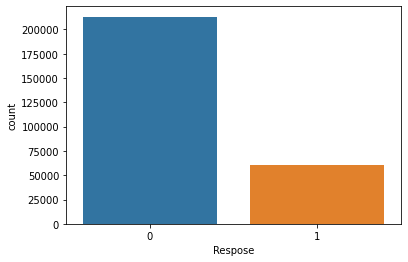

In [ ]:
sns.countplot(ready_data.Respose)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
def logistic_reg(data):
  # Create training and test sets
  X = data.iloc[:,:-1]
  y = data.iloc[:,-1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size = 0.4,
                                                      random_state=42,
                                                      stratify=y)
  kfold = StratifiedKFold(n_splits=5, random_state=42)

  logreg = LogisticRegression(max_iter=200,verbose=3,n_jobs=-1)

  # results = cross_val_score(logreg, X, y, cv=kfold, 
  #                           scoring='roc_auc',n_jobs=-1,verbose=3)
  # print(results)
  # print("ROC AUC: %.4f (%.4f)" % (results.mean(), results.std()))
  
  logreg.fit(X_train,y_train)
  y_pred_prob = logreg.predict_proba(X_test)[:,1]

  # Generate ROC curve values: fpr, tpr, thresholds
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()
  print(roc_auc_score(y_test, y_pred_prob))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


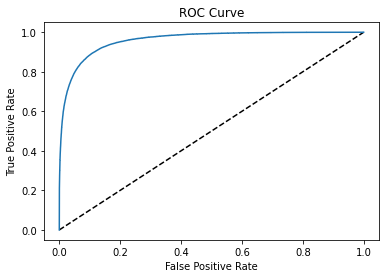

0.9603226900704769


In [ ]:
logistic_reg(ready_data)

After little hyperparameter tuning for delay_dep>15,1 else 0 
Logistic Regression ROC_AUC score 0.9604278754116565

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
def SGD_Classifier(data):
  # Create training and test sets
  X = data.iloc[:,:-1]
  y = data.iloc[:,-1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size = 0.4,
                                                      random_state=42,
                                                      stratify=y)
  sgdClass = SGDClassifier(loss='log',random_state=2019)
  sgdClass.fit(X_train,y_train)
  y_pred = sgdClass.predict(X_test)
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  print(accuracy_score(y_test,y_pred))

  y_pred_prob = sgdClass.predict_proba(X_test)[:,1]

  # Generate ROC curve values: fpr, tpr, thresholds
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  # Plot ROC curve
  import matplotlib.pyplot as plt
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()
  print(roc_auc_score(y_test, y_pred_prob))

[[71719 13540]
 [ 1615 22414]]
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     85259
           1       0.62      0.93      0.75     24029

    accuracy                           0.86    109288
   macro avg       0.80      0.89      0.83    109288
weighted avg       0.90      0.86      0.87    109288

0.8613296976795256


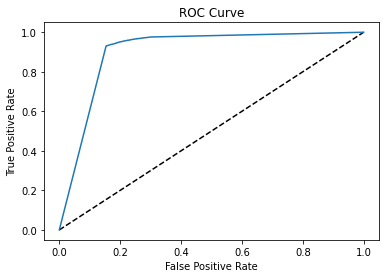

0.903296272500061


In [ ]:
SGD_Classifier(ready_data)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
def GaussianNB_clf(data):
  X = data.iloc[:,:-1]
  y = data.iloc[:,-1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.4,
                                                    random_state=42,
                                                    stratify=y)

  multinomial = GaussianNB()
  multinomial.fit(X_train, y_train) # Model Building: Apriori Probs Calculated

  y_probs = multinomial.predict_proba(X_test) # Posterior Probs Calculated
  y_pred = multinomial.predict(X_test) # Applying built on test data

  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  print(accuracy_score(y_test, y_pred))

  # ROC
  from sklearn.metrics import roc_curve, roc_auc_score

  # Compute predicted probabilities: y_pred_prob
  y_probs = multinomial.predict_proba(X_test)
  y_pred_prob = y_probs[:,1]

  # Generate ROC curve values: fpr, tpr, thresholds
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  # Plot ROC curve
  import matplotlib.pyplot as plt
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

  print(roc_auc_score(y_test, y_pred_prob))

[[66086 19173]
 [ 6643 17386]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     85259
           1       0.48      0.72      0.57     24029

    accuracy                           0.76    109288
   macro avg       0.69      0.75      0.71    109288
weighted avg       0.81      0.76      0.78    109288

0.7637801039455384


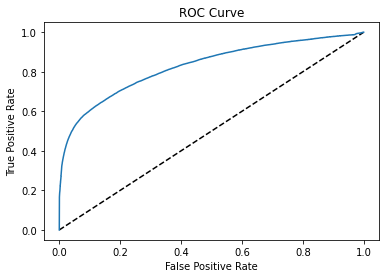

0.8279162400203455


In [ ]:
GaussianNB_clf(ready_data)

# ROC AUC Score 
## dep_delay > 5, 1 , 0

  - Logistic Reg - 0.917017734544309
  - SGD          - 0.8673806937370793
  - GaussianNB   - 0.7868807560048561

# ROC AUC Score 
## dep_delay > 15, 1 , 0

  - Logistic Reg - 0.9599819032713852
  - SGD          - 0.8205365918118336
  - GaussianNB   - 0.828511383202656

# ROC AUC Score 
## dep_delay > 15, 1 , 0  with addition columns lat,lon,alt

  - Logistic Reg - 0.9603226900704769
  - SGD          - 0.903296272500061
  - GaussianNB   - 0.8279162400203455